# Multi-resolution Coherent Scale separation (mrCOSTS) using PyDMD

This tutorial focuses on the real-world application the mrCOSTS object for multi-resolution coherent scale separation. In the toy-data example, the data include perfect oscillators as well as data engineered to be separable. Real world data is not so amiable. We provide this example with real data to illustrate that mrCOSTS works just as well on noisy, messy data. 

The real data also allows us to introduce the reason why mrCOSTS/COSTS operate with a different data model than the rest of PyDMD. Namely, mrCOSTS has _decomposition levels_ and _frequency bands_. The frequency bands are then further subdivided into the concepts of a _local_ and _global_ frequency bands. 

Each decomposition level provides a decomposition of the data by fitting BOP-DMD to a sliding window with a given length. For each decomposition level some number of _local_ frequency bands are found. The discrete frequency bands are found using a k-means clustering algorithm, introducing a hyperparameter of `n_components`. `n_components` can be specified for each level or given as an _a priori_ expectation. In either case, a frequency band separation results in separating the coherent spatiotemporal features for each decomposition level. 

mrCOSTS operates the opposite of other decompositions, fitting the fastest frequency bands and moving to the slowest. After separating the local frequency bands all but the slowest frequency band are removed from the data. The slowest frequency band is then given to the  next largest decomposition level (with a larger window) to fit.

After all decompositions have been completed, it is typical for information in a given frequency band to leak between decomposition levels. For this reason, _global_ frequency bands are found. These global frequency bands are then used to describe the discrete, coherent spatiotemporal features from the data.

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pandas as pd
import copy
import scipy

# OS interaction
import os
import sys
import glob

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# PyDMD
from pydmd.costs import COSTS
from pydmd.mrcosts import mrCOSTS

import warnings
warnings.filterwarnings('ignore')

# Helper functions
sys.path.append('../../helpers')
import get_project_path
dir_helpers, dir_project, dir_data = get_project_path.project_paths()

## Format plots

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    '#4477AA',
    '#CCBB44',
    '#EE6677',
    '#228833',
    '#66CCEE',
    '#AA3377',
    '#BBBBBB'
]
sns.set_palette(sns.color_palette(tol_bright_reorder))

In [3]:
# DTS data
dir_essd = os.path.join(dir_data, 'original/love19/ESSD-repository/')
dir_dts_essd = os.path.join(dir_essd, 'FODS/outer-array')
dir_processed = os.path.join(dir_data, 'processed/love19')

# Figures
dir_print = os.path.join(dir_project, 'figures/mrDMD/recursive sliding mrDMD scale separation, Spring 23')
dir_results = os.path.join(dir_project, 'data/costs-results/love19/initial-tests')

# Data

These data come from the Large-eddy Observatory, Voitsumra Experiment 2019 (LOVE19). They are distributed temperature observations at 1 s and 0.127 m resolution along a 12 m tower in a valley bottom. These data are great for demonstrating the mrCOSTS because:

- They include a wide range of process scales that are not separable by other methods. Separating these scales is considered one of the biggest open questions boundary layer meteorology.
- There is substantial sensor noise. For the purposes of the tutorial we remove much of this noise using a rolling mean. mrCOSTS would determine the sensor noise and the small-scale turbulent processes as non-coherent. Consequently, mrCOSTS would drop them. However, the amplitudes of these scales are small but computationally expensive. The purpose of the rolling mean is to enable a quicker fitting process since we can skip right to the scale of the coherent processes.
- The data are 1D, which is simpler to visualize.

In [4]:
os.chdir(dir_processed)

ds_obs = xr.open_dataset('tower-cold.nc')

In [5]:
ds_obs = ds_obs.sel(time=slice('2019-07-22 22:00', '2019-07-22 23:00')).load()
ds_obs['Tperturb'] = ds_obs.cal_temp - ds_obs.cal_temp.mean(dim='z')
ds_obs['Tperturb'].attrs['units'] = 'K'
ds_obs['Tperturb'].attrs['long_name'] = r'$\theta - <{\theta}>$'
ds_obs

<xarray.Dataset>
Dimensions:   (time: 3660, z: 80)
Coordinates:
  * time      (time) datetime64[ns] 2019-07-22T22:00:00 ... 2019-07-22T23:00:59
    x         (z) float64 -14.15 -14.14 -14.14 -14.13 ... -13.87 -13.87 -13.86
  * z         (z) float64 0.7173 0.8461 0.9749 1.104 ... 10.51 10.64 10.77 10.9
    LAF       (z) float64 181.9 182.1 182.2 182.3 ... 191.6 191.7 191.9 192.0
    y         (z) float64 -9.188 -9.189 -9.19 -9.191 ... -9.278 -9.279 -9.28
    lnz       (z) float64 -0.3323 -0.1671 -0.02538 0.09874 ... 2.364 2.376 2.388
Data variables:
    cal_temp  (z, time) float64 11.27 10.45 10.26 10.49 ... 14.17 14.46 14.54
    theta     (z, time) float64 15.28 14.45 14.26 14.49 ... 18.23 18.52 18.6
    dT_dz     (z, time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    dT_dlnz   (z, time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Tperturb  (z, time) float64 -1.513 -2.227 -2.296 ... 1.596 1.934 2.008
Attributes:
    dt:       1s
    dLAF:     0.127

In [6]:
ds_data = ds_obs.Tperturb.dropna(dim='time')
ds_data = ds_data.rolling(time=45, center=True).mean().dropna(dim='time', how='all')
ts = ds_data.time
ts = ts - ts.isel(time=0)
ts = (ts / 1e9).values.astype(float)

data = ds_data.values

Text(0.5, 1.0, 'Input data for mrCOSTS')

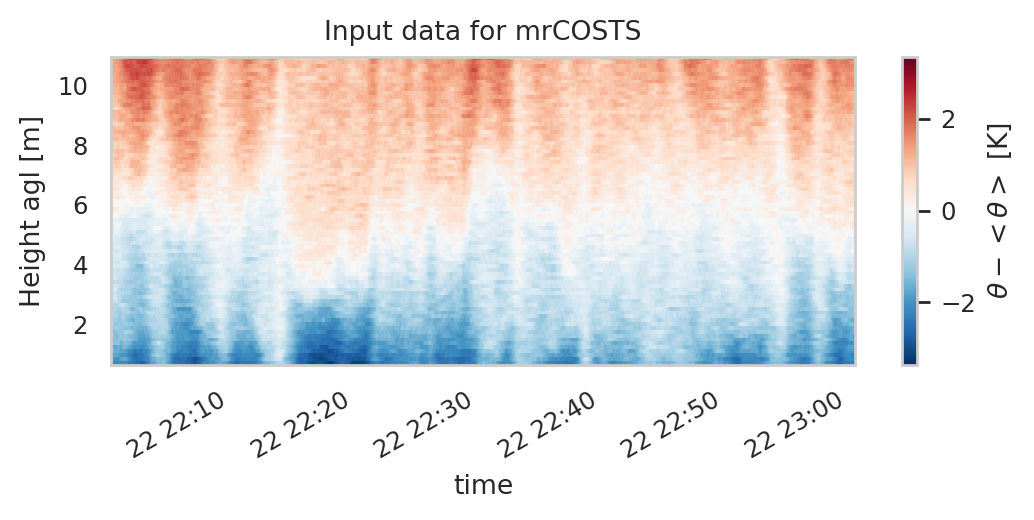

In [7]:
ds_data.plot(figsize=(6, 2))
plt.gca().set_title('Input data for mrCOSTS')

# Scale separation with the mrCOSTS object

Here we have a number of important keyword arguments and hyperparameters.

In [8]:
# Parameters
window_lengths = np.array([30, 60, 120, 240, 480]) * 5
step_sizes = np.array([2, 4, 8, 16, 32]) * 5
sr = 12
svd_ranks = [sr] * len(window_lengths)
global_svd_array = [False] * len(window_lengths)
strategy = 'svd-rank={}_dyadic-windows.smoothed-data'.format(sr)
data_name = 'july22nd_2200-2300_gravity-waves.tower'

In [9]:
drive = False

if drive:
    mrc = mrCOSTS(
        svd_rank_array=svd_ranks,
        window_length_array=window_lengths,
        step_size_array=step_sizes,
        global_svd_array=global_svd_array,
        cluster_sweep=True,
    )

    mrc.fit(data, np.atleast_2d(ts))

## I/O

Due to the computation expense of the mrCOSTS fitting, it is desirable to execute this step only once, save the results, and only operate on the saved results. For this reason, we built mrCOSTS to be compatible with xarray, enabling storage as a self-describing dataset in netcdf format. This way results can be operated on offline without any further fitting.

### To netcdf

In [10]:
if drive:
    os.chdir(dir_results)
    filename = '.'.join([data_name, strategy])
    mrc.to_xarray(filename)
    

### Convert from netcdf

In [11]:
os.chdir(dir_results)
file_list = glob.glob('*' + strategy + '*.nc')
mrc = mrCOSTS()
mrc.from_xarray(file_list)

# Evaluation plots

## Individual decomposition level comprehensive plots

These plots can be easily iterated through. But for the purpose of the tutorial, we present only a single tutorial.

The plot types all  assume 1D data (as this is the shape required by PyDMD). We chose to not develop other visualization methods since the dimensionality of data can change dramatically between applications. However, if there is a consistent use case additional evaluation plots can (and should!) be added.

Plot types for each local decomposition:
1) Histogram of DMD frequencies ($\omega$). There are several options for how to express $\omega$: $|\omega|$, $\omega^2$, $log(\omega)$.
2) Error in the global reconstruction expressed as a percent
3) Coherent scale separation with input data and each discrete frequency band.
4) Coherent scale separation with input data, low frequency component, and the high frequency component. The low frequency component is the input for the next decomposition scale.
5) Time series of the scale separation at a single point given by `space_index`.

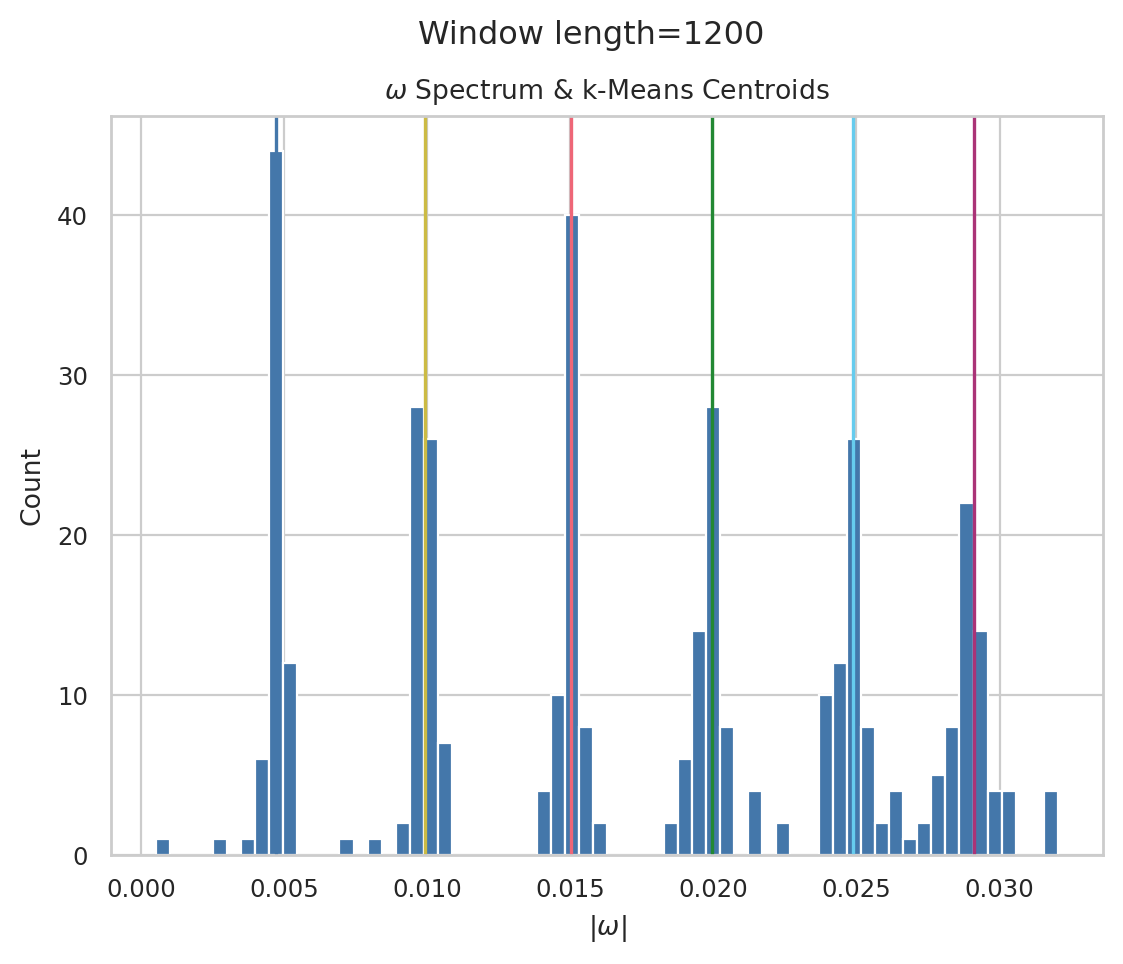

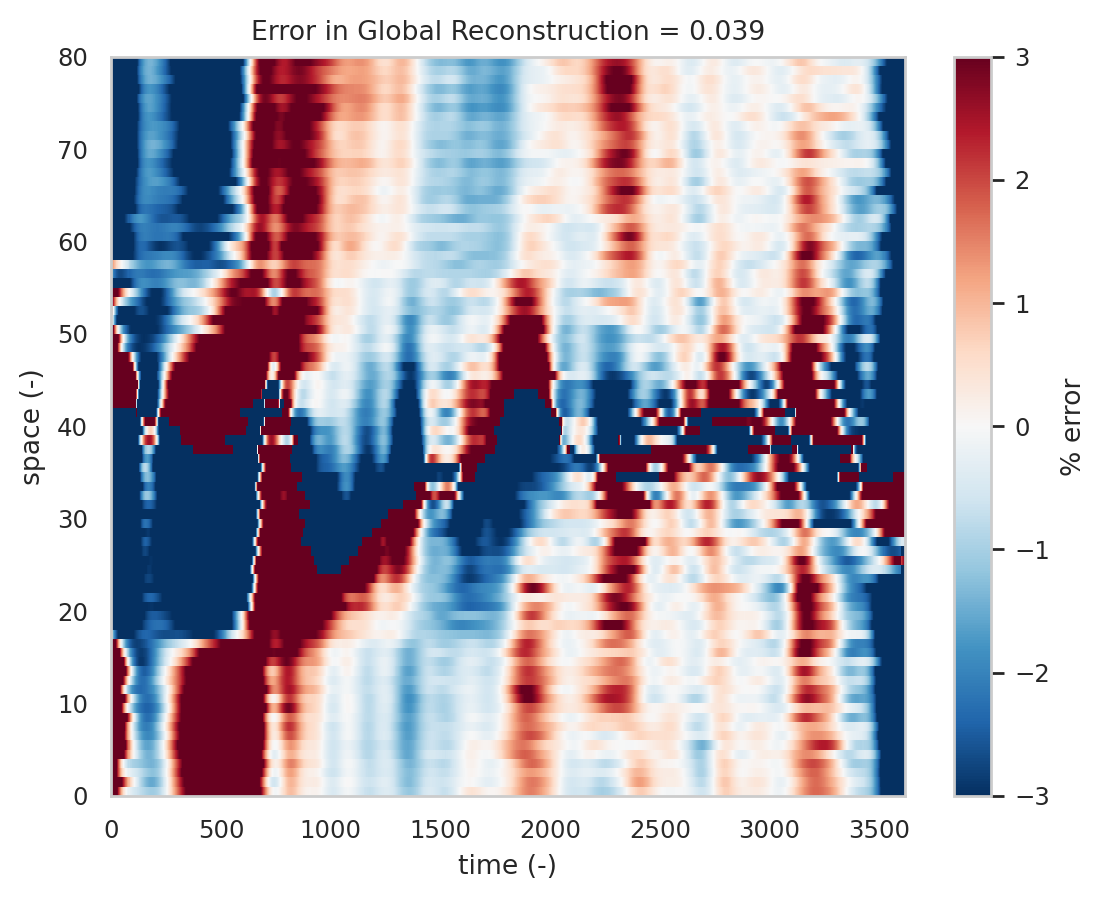

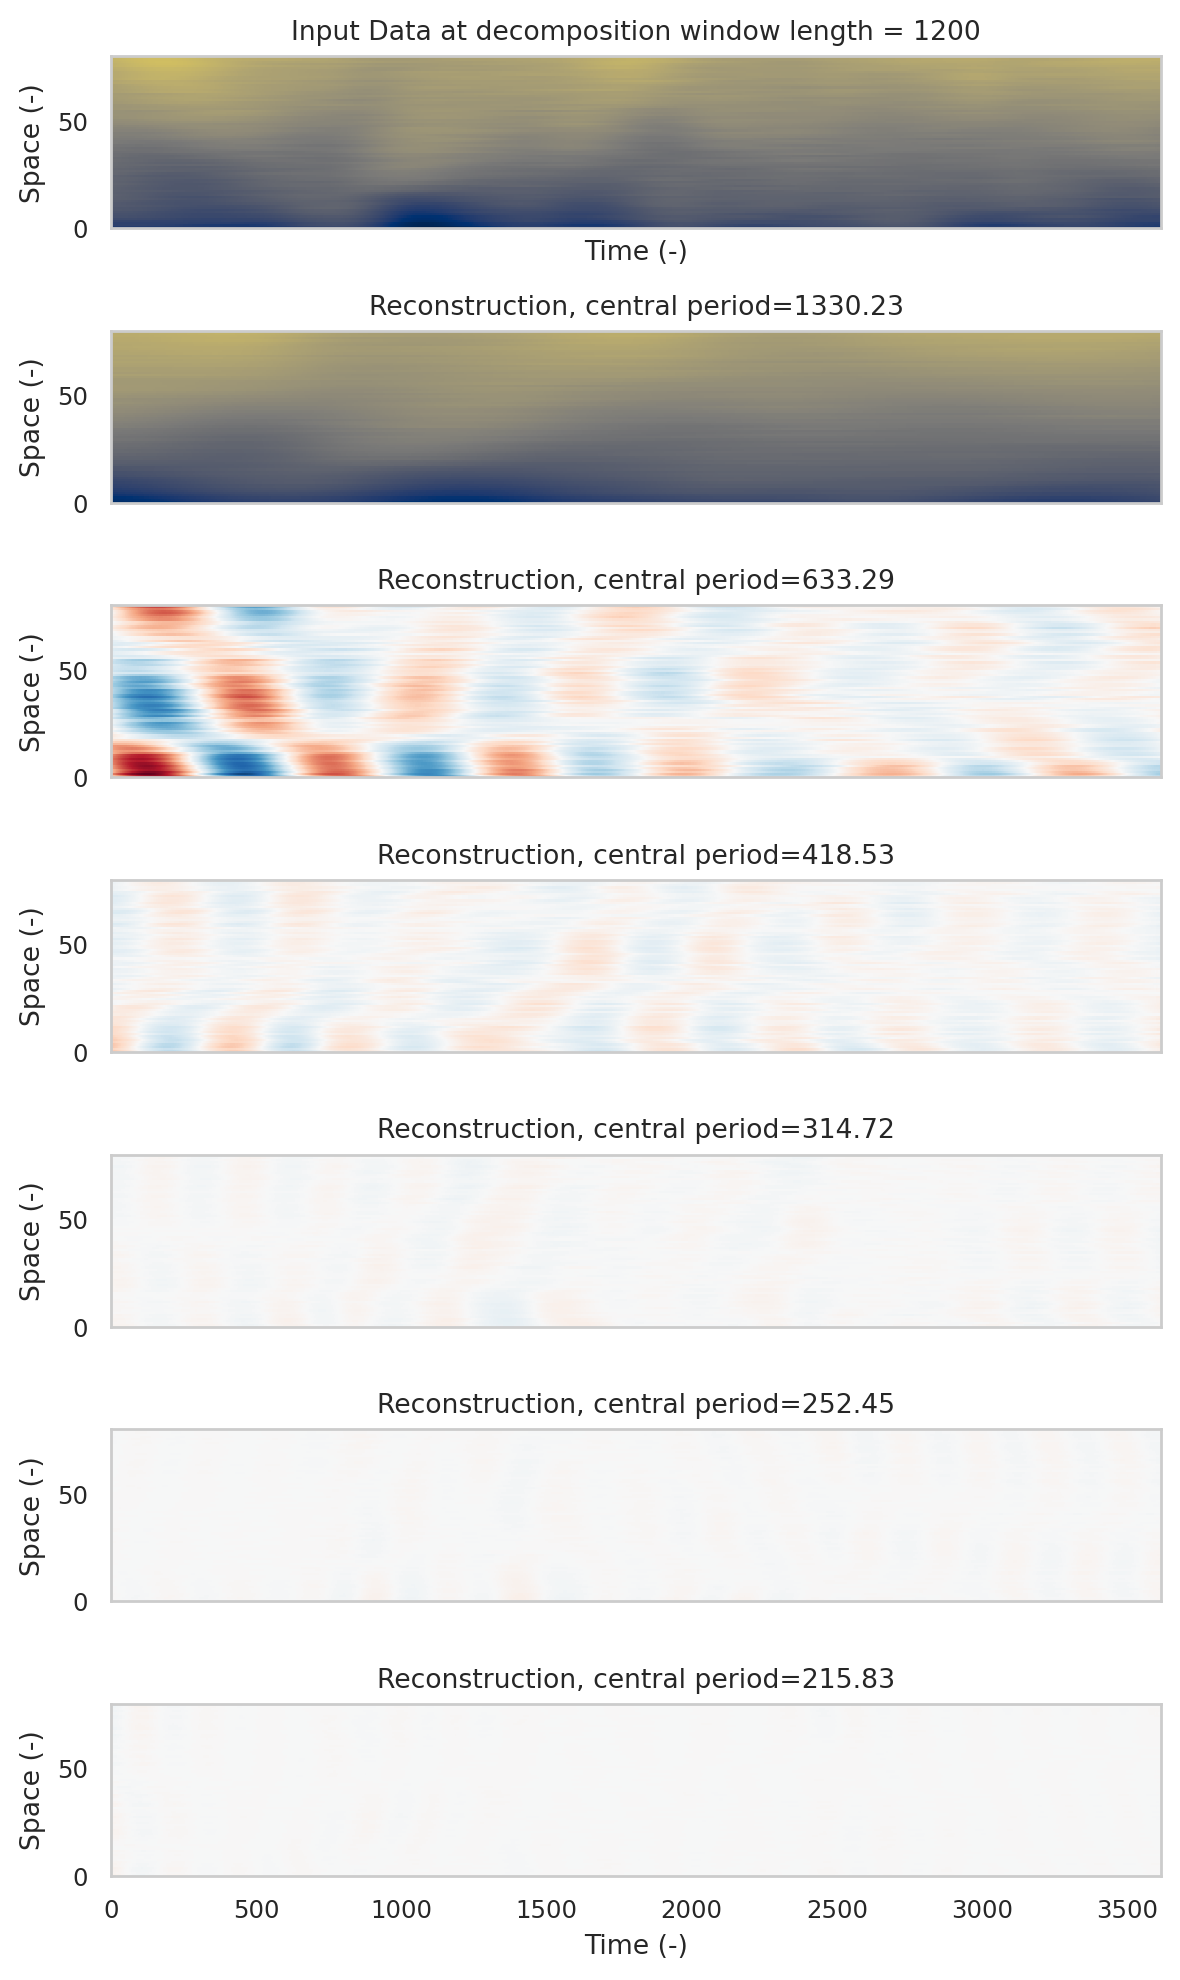

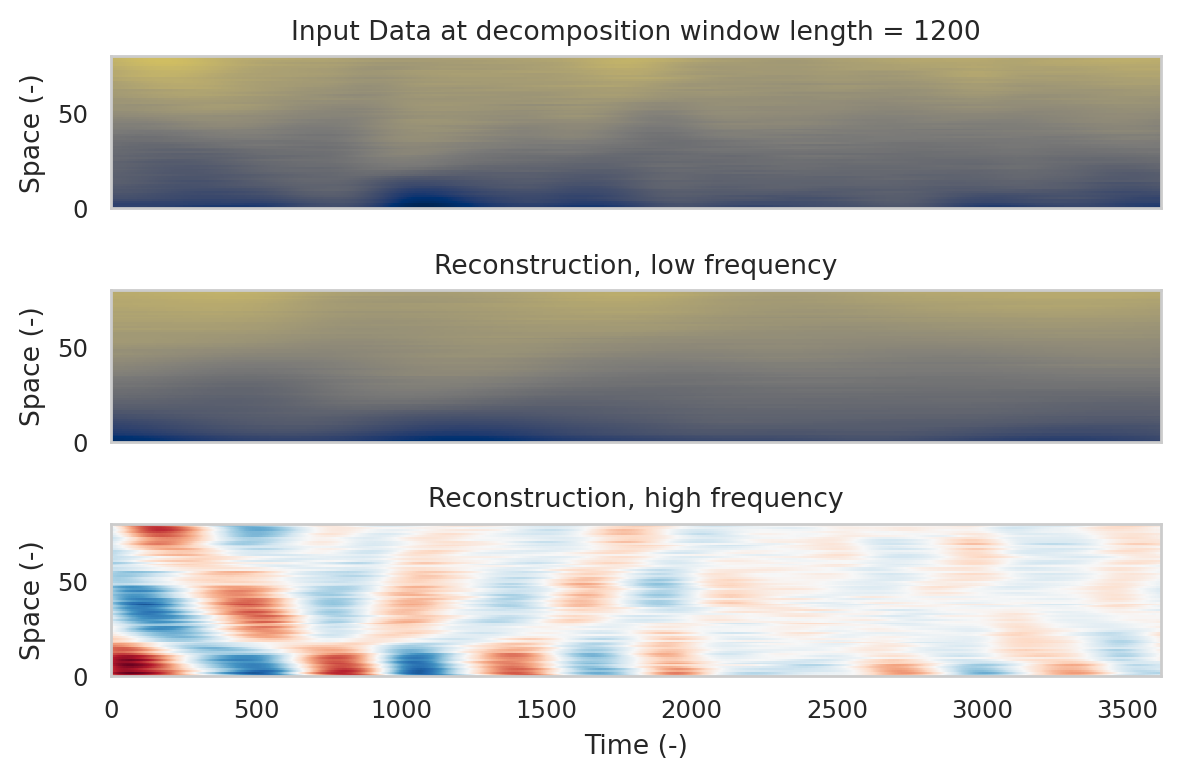

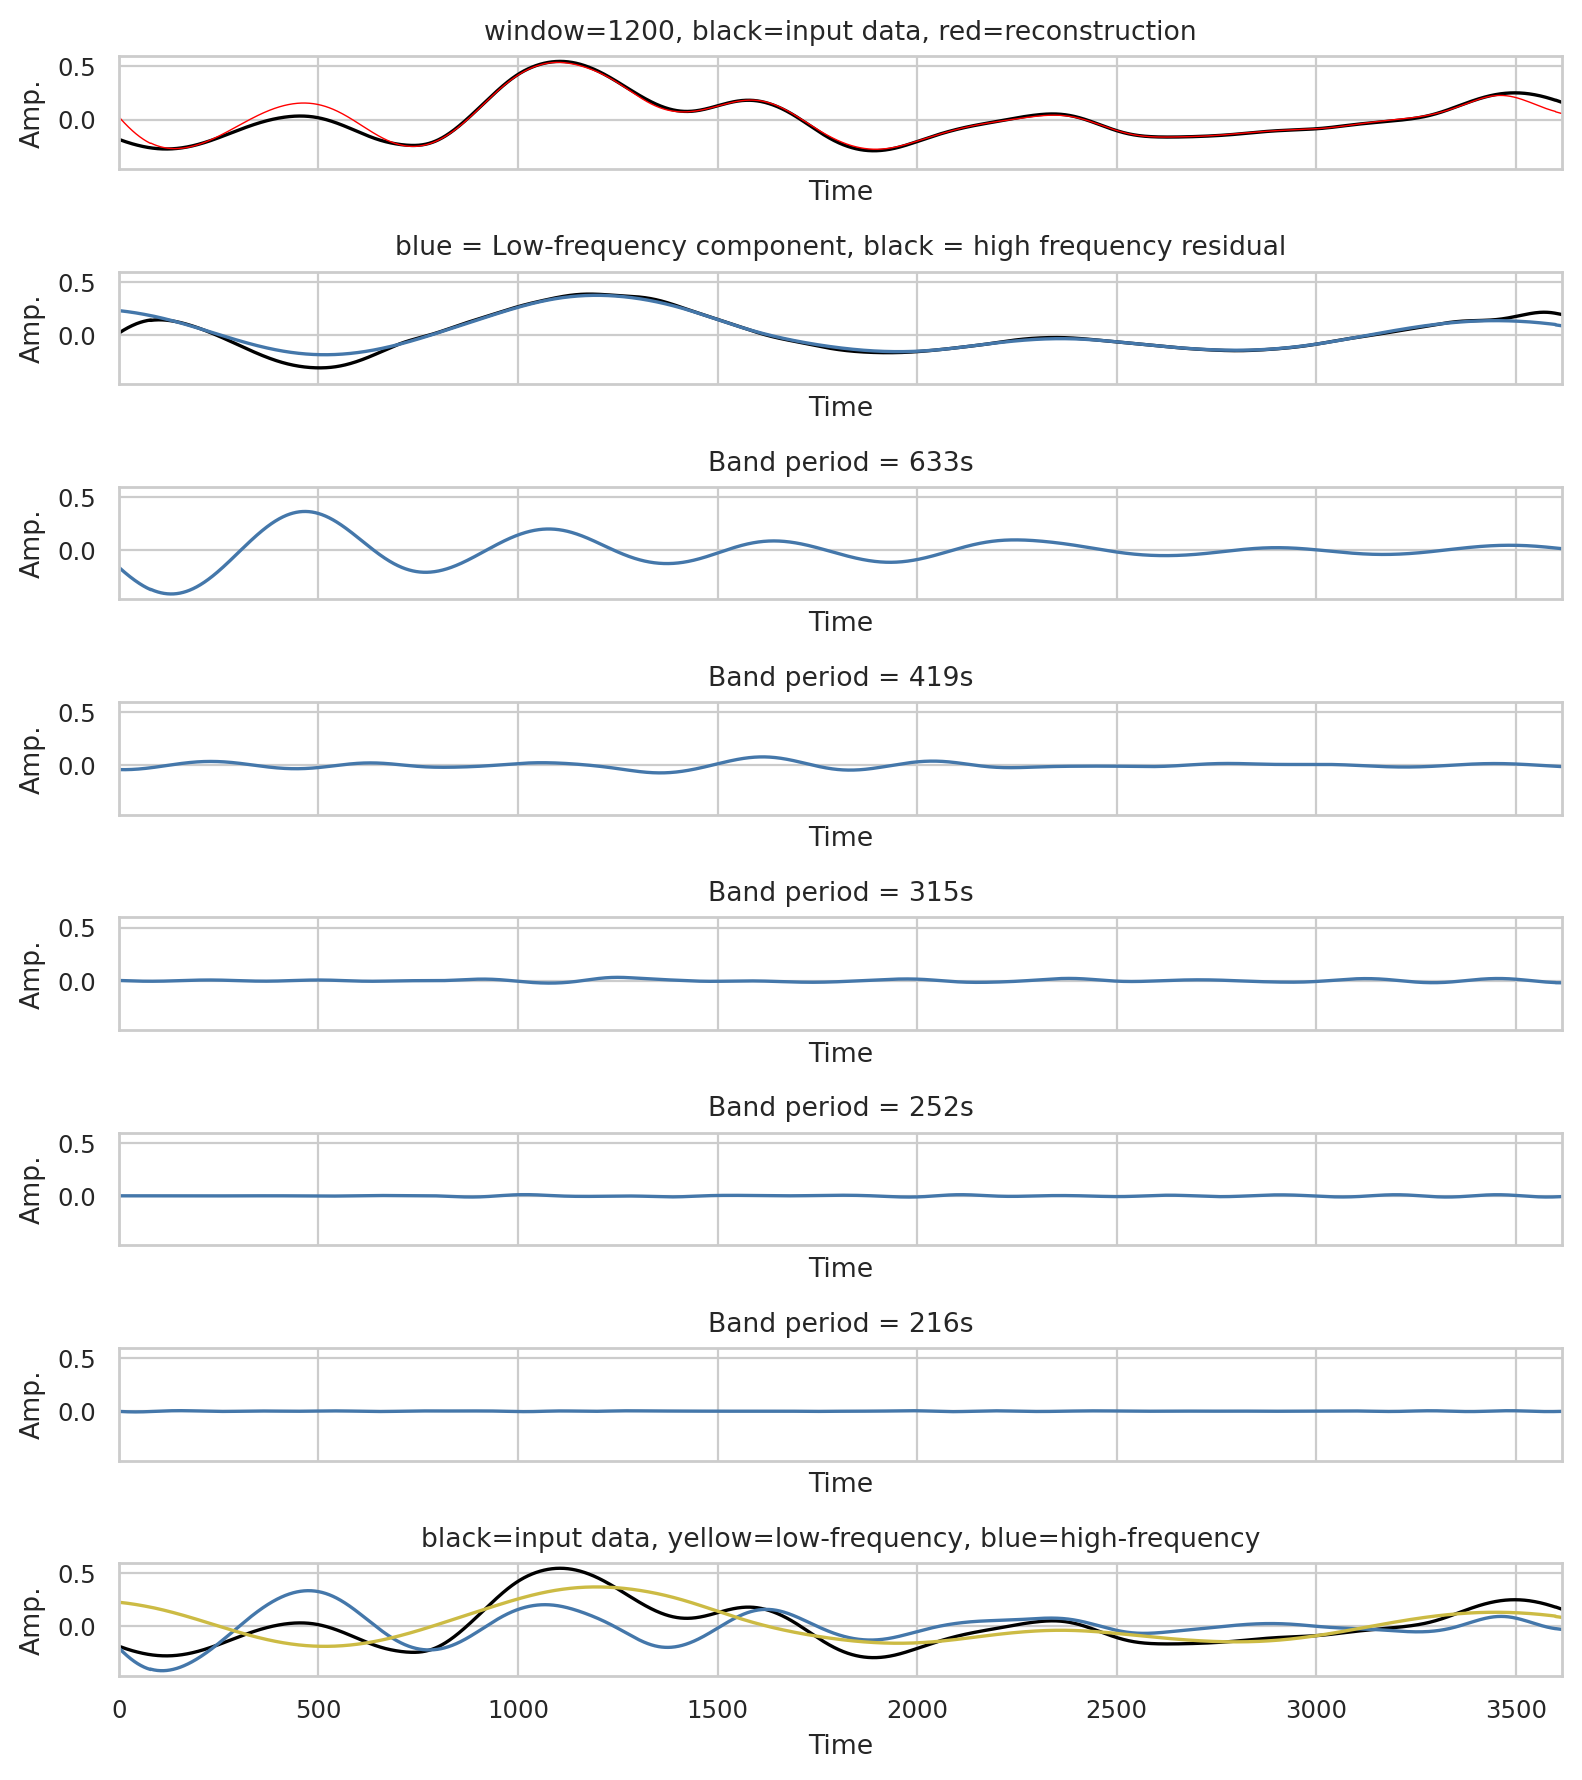

In [66]:
n_decomp = 3
mrd = mrc.costs_array[n_decomp]

# The data for each decomposition level is built here to avoid
# reconstructing the data for each plot. If this is not done the
# plots can still be rendered but will take slightly longer.
if n_decomp == 0:
    x_iter = data
else:
    x_iter, _ = mrc.costs_array[n_decomp - 1].scale_separation(
        scale_reconstruction_kwargs=mrc._costs_recon_kwargs
    )

fig1, ax1 = mrd.plot_omega_histogram()
fig1.suptitle("Window length={}".format(mrd.window_length))

# Error in global reconstruction
mrc.plot_local_error(
    n_decomp,
    data=x_iter,
    scale_reconstruction_kwargs=mrc._costs_recon_kwargs
)

# Scale separation
_ = mrc.plot_local_reconstructions(
    n_decomp,
    data=x_iter,
    kwargs={'plot_period': True},
    scale_reconstruction_kwargs=mrc._costs_recon_kwargs,
)
_ = mrc.plot_local_scale_separation(
    n_decomp,
    data=x_iter,
    scale_reconstruction_kwargs=mrc._costs_recon_kwargs
)

# Single points in space
space_index = 40
_, _ = mrc.plot_local_time_series(
    space_index,
    n_decomp,
    x_iter,
    scale_reconstruction_kwargs=mrc._costs_recon_kwargs
)
        

## All decomposition levels

This next plot gives a sense of how mrCOSTS performs across all decomposition levels. For each level the high frequency component, which is removed, and the low-frequency component, which is passed to the next level, are shown. Since the low-frequency component includes the slow evolving background values it is plotted in a perceptually uniform color scale. The high frequency component is perturbations around zero so it is plotted in a diverging color scale. All levels are plotted using the same color map scaling.

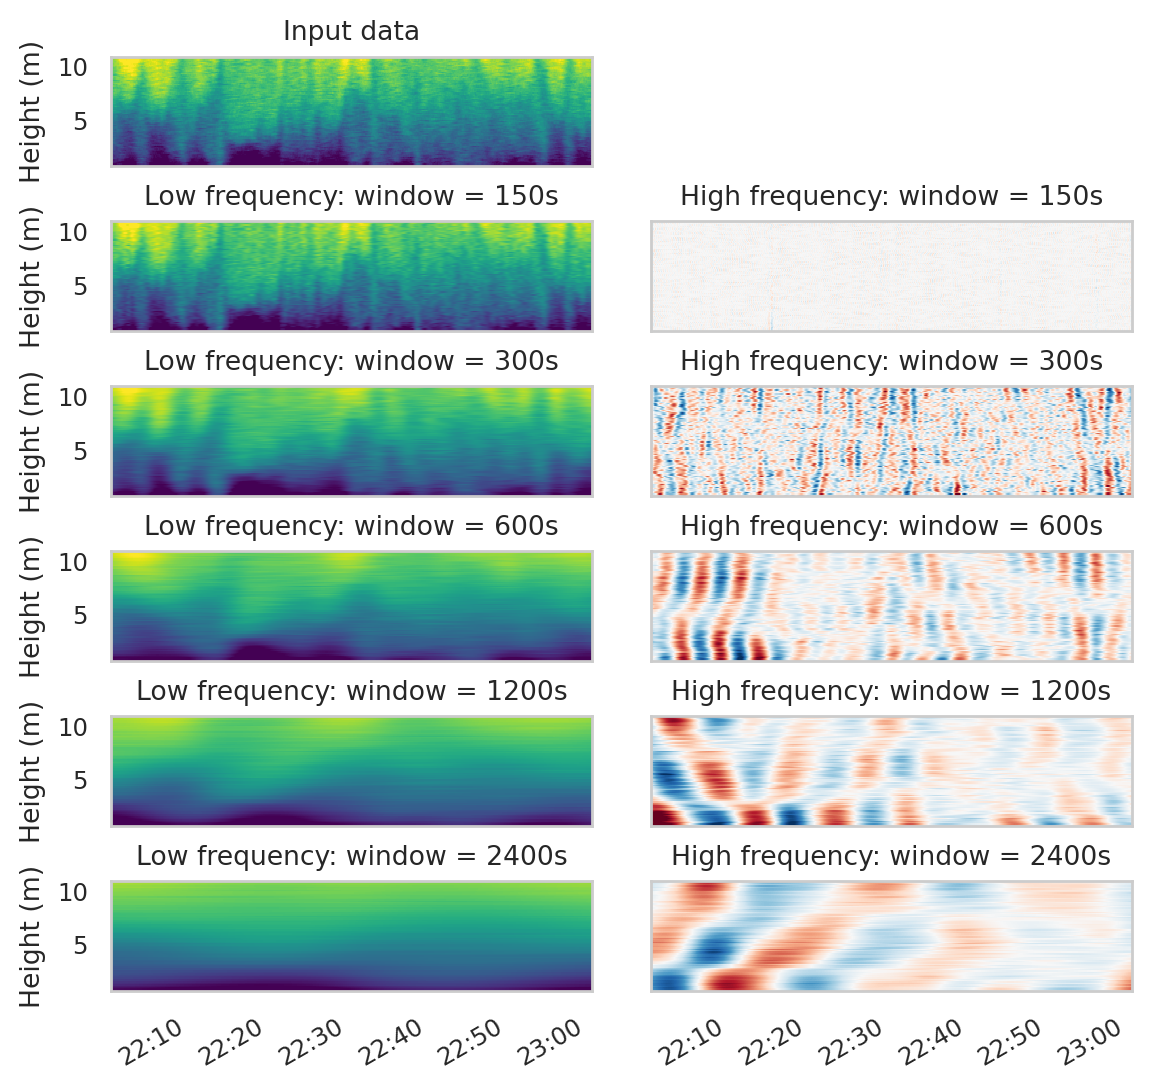

In [14]:
vscale = 0.5
fig, axes = plt.subplots(
    mrc.n_decompositions + 1,
    2,
    figsize=(6, mrc.n_decompositions * 1.25),
    sharex=True,
    sharey=True
)

plot_kwargs = {
    'cmap': 'RdBu_r',
    'vmin': -vscale,
    'vmax': vscale,
}

plot_kwargs_lf = {
    'cmap': 'viridis',
    'vmin': -2,
    'vmax': 2,
}

ax = axes[0, 0]
ax.pcolormesh(ds_data.time.values, ds_data.z.values, data, **plot_kwargs_lf)
ax.set_title('Input data')
ax.set_ylabel('Height (m)')

axes[0, 1].axis('off')
for nm, m in enumerate(mrc.costs_array):
    xr_low_frequency, xr_high_frequency = m.scale_separation()

    ax = axes[nm + 1, 1]
    ax.pcolormesh(ds_data.time.values, ds_data.z.values, xr_high_frequency, **plot_kwargs)
    ax.set_title('High frequency: window = {}s'.format(m._window_length))
    
    ax = axes[nm + 1, 0]
    ax.pcolormesh(ds_data.time.values, ds_data.z.values, xr_low_frequency, **plot_kwargs_lf)
    ax.set_title('Low frequency: window = {}s'.format(m._window_length))
    ax.set_ylabel('Height (m)')

axes[-1, 0].xaxis.set_major_formatter(DateFormatter('%H:%M')) 
    
fig.tight_layout()
fig.autofmt_xdate()

However, there is a problem masked in these data: a given frequency band tends to leak between levels. This leaking forms a major obstacle since it means a frequency band found at any given level is missing information that likely leaked to the next level.

# Global clustering and frequency band separation

Some information at a given frequency band appears to "leak" from one level to the next. Generally, the amplitudes are mostly confined to a single decomposition level, but not enough to discard frequency bands from other decomposition levels. The exact cause of this leaking is uncertain for now (bad fits? over fitting? not handling noise?).

But, given this information leaking, it is necessary to do a "global" clustering and scale separation on the entire multi-resolution decomposition. This global scale separation should then be used in place of the "local" scale separation shown in the above evaluation plots.

## Interpolate to common time step

The biggest issue in the global scale separation is the different number of fitted windows for each decomposition level. To get around this issue we need to somehow normalize between the many windows in the first decomposition level (with the smallest windows) with the small number of windows in the last decomposition level (with the largest windows)/

We chose to interpolate all decomposition levels to the time step of the smallest time step from the first decomposition level. 

In this multi-resolution interpolation step the low frequency cluster is removed and replaced by nans.

In [15]:
mrc.multi_res_interp()
df = mrc._da_omega.to_dataframe()

## Visualizing the leaking

First, let's take a look at the typical spaces used for clustering:
- $\frac{\omega}{2 \pi}^{2}$ (squared frequency, as in Dylewsky et al., 2019)
- $\frac{\omega}{2 \pi}$ (frequency)
- $\frac{2 \pi}{\omega}$ (period)

In all of these cases the colors indicate the decomposition level in which $\omega$ was found. You'll notice that the $\omega$ values frequently overlap between levels.

Text(0.5, 0, 'Period (s)')

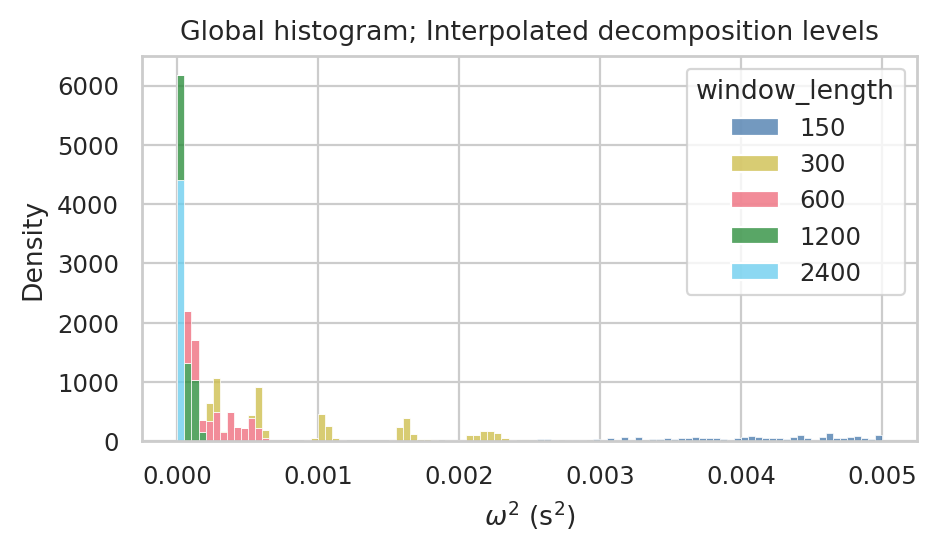

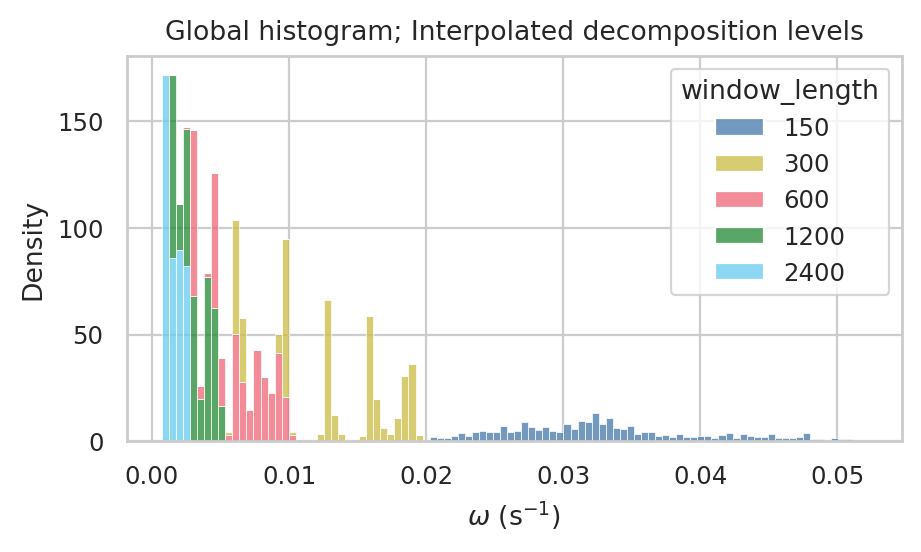

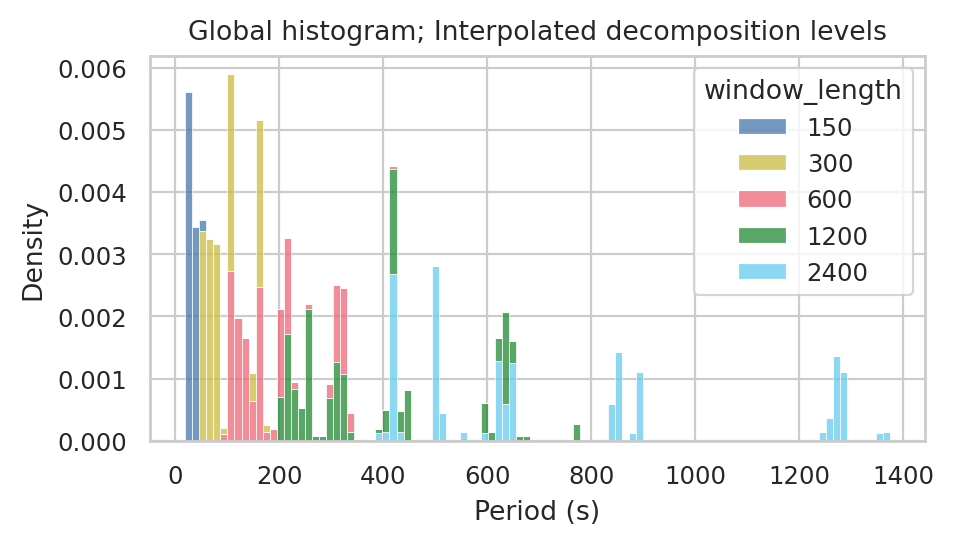

In [16]:
# Squared frequencies
plt.figure(figsize=(5, 2.5))
sns.histplot(
    data=df.reset_index(),
    x=np.abs(df.omega.values.imag) ** 2 / (2 * np.pi),
    hue=df.reset_index()['window_length'].astype(str),
    common_bins=True,
    common_norm=True,
    stat='density',
    multiple='stack',
    binrange=(0, 0.005),
    bins=100,
)
plt.gca().set_title('Global histogram; Interpolated decomposition levels')
plt.gca().set_xlabel(r'$\omega^2$ (s$^2$)')

# Frequency
plt.figure(figsize=(5, 2.5))
sns.histplot(
    data=df.reset_index(),
    x=np.abs(df.omega.values.imag) / (2 * np.pi),
    hue=df.reset_index()['window_length'].astype(str),
    common_bins=True,
    common_norm=True,
    stat='density',
    multiple='stack',
    bins=100,
)
plt.gca().set_title('Global histogram; Interpolated decomposition levels')
plt.gca().set_xlabel(r'$\omega$ (s$^{-1}$)')

# Period
plt.figure(figsize=(5, 2.5))
sns.histplot(
    data=df.reset_index(),
    x=2 * np.pi / np.abs(df.omega.values.imag),
    hue=df.reset_index()['window_length'].astype(str),
    common_bins=True,
    common_norm=True,
    stat='density',
    multiple='stack',
    bins=100,
)
plt.gca().set_title('Global histogram; Interpolated decomposition levels')
plt.gca().set_xlabel('Period (s)')

In all of these cases we see that processes were fit across multiple decomposition windows. For instance there is a frequency band around 600 s which was fit in both the 1200 s and 2400 s windows.

However, all of the choices for expressing $\omega$ compress some range of the data either emphasizing the largest or smallest scales. For instance, the squared frequencies effectively compress the top three decomposition levels (600 s to 2400 s) into one super cluster. A physical interpretation of these toy data suggests we should not expect this.

Instead, let us try to cluster in a logarithmic space. From here on out I will be choosing to use periods simply because those quantities are easier to physically interpret for these toy data. Incidentally, once we transform to a logarithmic space, the choice of quantity (e.g. $\omega^2$ vs $\omega$) is immaterial due to the log transformation.

## Cluster in a log scale

Text(0.5, 0, 'Period (s)')

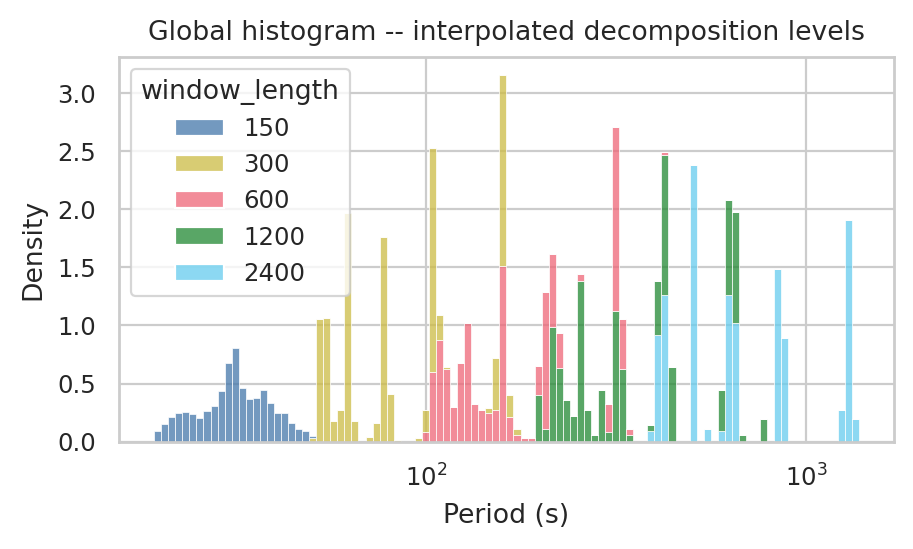

In [17]:
plt.figure(figsize=(5, 2.5))
sns.histplot(
    data=df.reset_index(),
    x=2 * np.pi / np.abs(df.omega.values.imag),
    hue=df.reset_index()['window_length'].astype(str),
    common_bins=True,
    common_norm=True,
    log_scale=True,
    stat='density',
    multiple='stack',
    bins=100,
)
plt.gca().set_title('Global histogram -- interpolated decomposition levels')
plt.gca().set_xlabel('Period (s)')



Now we more nicely see the expected frequency band separation (although log(period) was plotted). Fortunately, the log-scale makes the period vs frequency vs squared-frequency distinction irrelevant as they all transform to identical distributions.

The problem of processes being fit across multiple scales now becomes more apparent as well. To address the information leaking a global scale separation is performed.

## Global Clustering

As with the local clustering, the global clustering makes use of the MiniBatches k-means clustering from sklearn. The free parameter is again the number of components, `n_components`. We could probably make a reasonable guess for the optimal number of clusters to fit. But, a hyperparameter sweep function is provided when the optimal number is unclear or to enable objective selection.

Notes:
- The silhouette scoring is the slowest part of the hyperparameter sweep.
- The calinski-harabasz score is not useful due to (nearly) monotonically increasing with `n_components`. It can be used instead of the silhouette score but is not recommended.

fitting n_components = 10
scoring
fitting n_components = 11
scoring
fitting n_components = 12
scoring
fitting n_components = 13
scoring
fitting n_components = 14
scoring
fitting n_components = 15
scoring
fitting n_components = 16
scoring
fitting n_components = 17
scoring
fitting n_components = 18
scoring
Optimal silhouette score is = 17


Text(0.5, 0, 'Silhouette score (-), (1 is best, -1 is worst)')

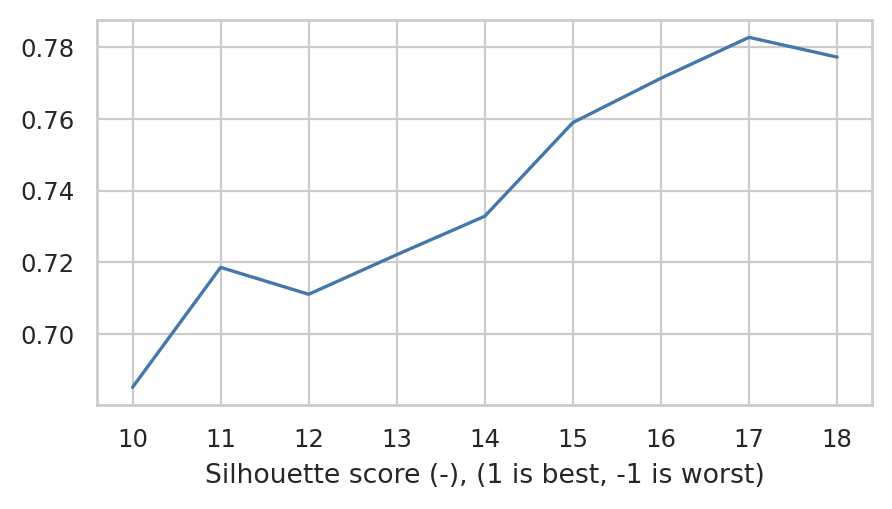

In [18]:
n_components_range = np.arange(10, 19)
scores, n_optimal = mrc.global_cluster_hyperparameter_sweep(
    n_components_range,
    method='log10',
)

print('Optimal silhouette score is = {}'.format(n_optimal))
plt.figure(figsize=(5, 2.5))
plt.plot(n_components_range, scores)
plt.gca().set_xlabel('n_components (-)')
plt.gca().set_xlabel('Silhouette score (-), (1 is best, -1 is worst)')

In [19]:
cluster_centroids, omega_classes, omega_array = mrc.global_cluster_omega(
    n_optimal,
    method='log10'
)

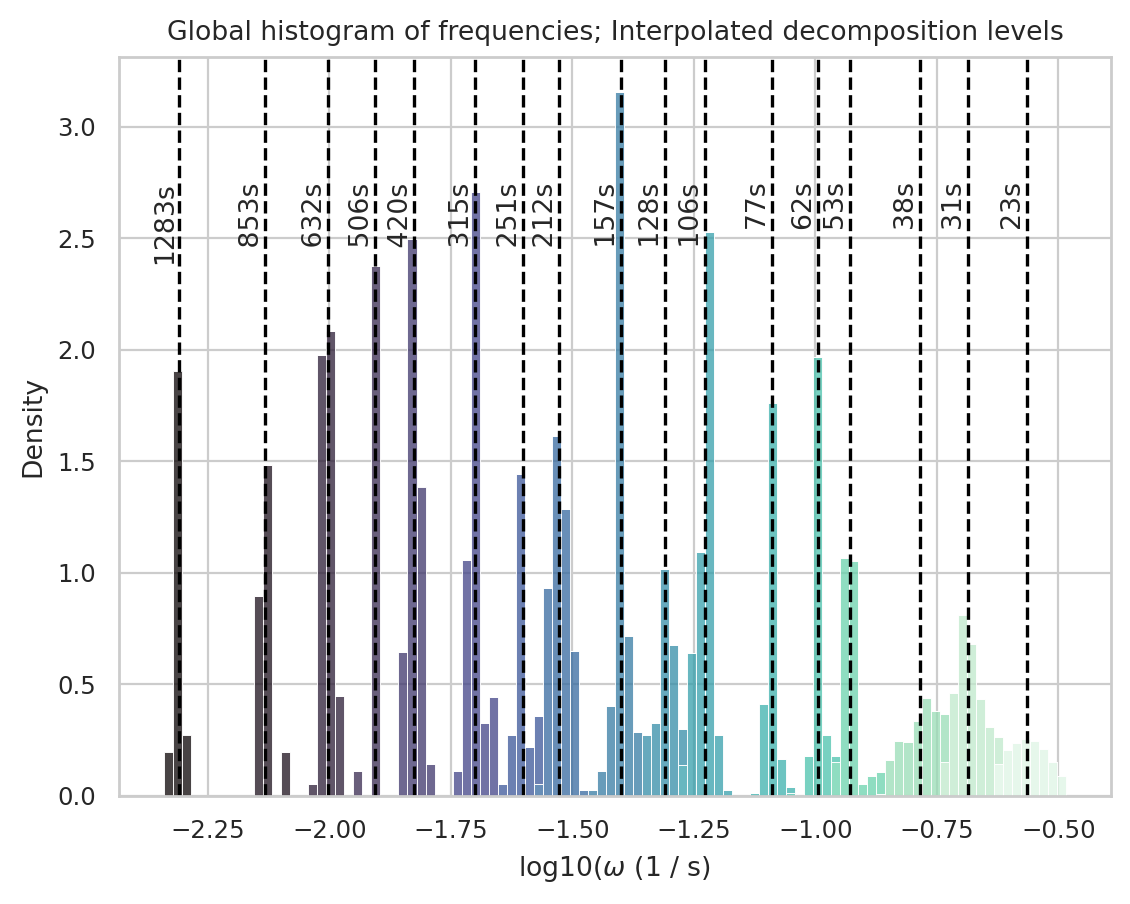

In [20]:
hue_order = np.arange(len(np.unique(omega_classes))).astype(str)

sns.histplot(
    x=omega_array,
    hue=omega_classes,
    hue_order=hue_order,
    common_bins=True,
    common_norm=True,
    stat='density',
    multiple='stack',
    bins=100,
    palette='mako',
    legend=False,
)

ax = plt.gca()
ax.set_title('Global histogram of frequencies; Interpolated decomposition levels')
ax.set_xlabel(r'log10($\omega$ (1 / s)')
[ax.axvline(c, color='k', ls='--') for nc, c in enumerate(cluster_centroids)];
[
    ax.text(
        c,
        2.75,
        '{:4.0f}s'.format(1 / (10 ** (c) / (2 * np.pi))),
        rotation='vertical',
        va='top',
        ha='right'
    ) for c in cluster_centroids
];

We now have discrete frequency bands giving us the coherent spatialtemporal modes found by mrCOSTS. This is not meant to be a dimensionality reduction since we have gone from 80 spatial points into 17 coherent spatialtemporal modes. Instead, these are the physically meaningful processes resolvable by this observation method which would be otherwise extremely difficult to infer. 

Notes:

- We have now clearly captured the distinct frequency bands, regardless of which decomposition level they originally came from.
- There is still some undesirable behavior as the highest frequency band was split into three. Physically, we would expect this highest frequency band to be made up of a melange of small scale processes that are only partially captured by the instrument. The clustering says this melange is three distinct time scales.
- Decreasing `n_components` does not address the "over-clustered" high frequencies. Instead, the lower frequency components are merged into neighboring clusters. We have a good physical reason to believe we have distinct frequency bands at the longer time scales and not at a the small scales. This example highlights the frequency band scale separation is not an "fire and forget" process but requires physical interprettation of results _a posteriori_.

# Visualizing the global scale separation

## "Un-interpolate"

The first step is to "un-interpolate" the clustering results from the fine time step of the first decomposition level to the original time step for each decomposition level. Here a nearest neighbor look up is used to find the cluster classification for $\omega$ for each decomposition level.

In [21]:
omega_classes_list = mrc.multi_res_deterp(omega_classes)

First, the mrCOSTS fit is used to reconstruct the discrete frequency bands. The resulting data is of the dimensions `n_decomp` x `n_frequency_bands` x `n_space` x `n_time`. In other worse, the 1D profile now has two more dimensions. 

The low-frequency background mode was excluded in the last decomposition level but it is necessary to include this component when reconstructing.

In [22]:
xr_sep = mrc.global_scale_reconstruction(
    n_optimal,
    omega_classes_list,
)

xr_background = mrc.get_background()

Now we plot the time-space cross sections for each coherent spatiotemporal mode.

As mentioned above, the high frequency component was split up across three clusters. Since processes at these fine time scales are anticipated to be poorly resolved by the instrument as well as being stochastic in nature, we simply exclude them here.

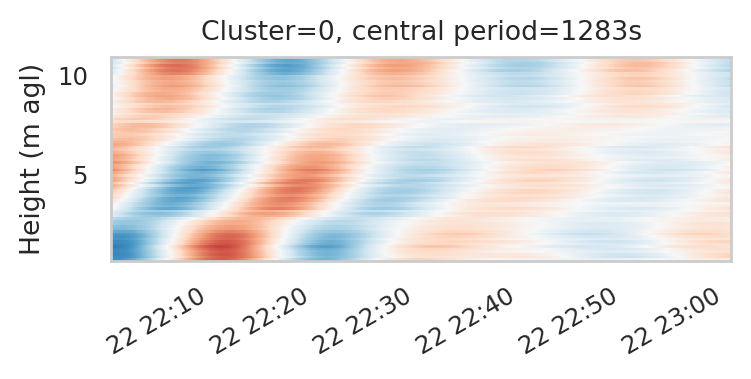

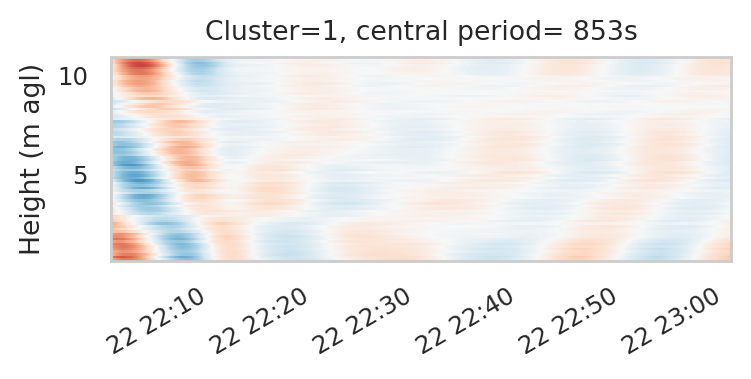

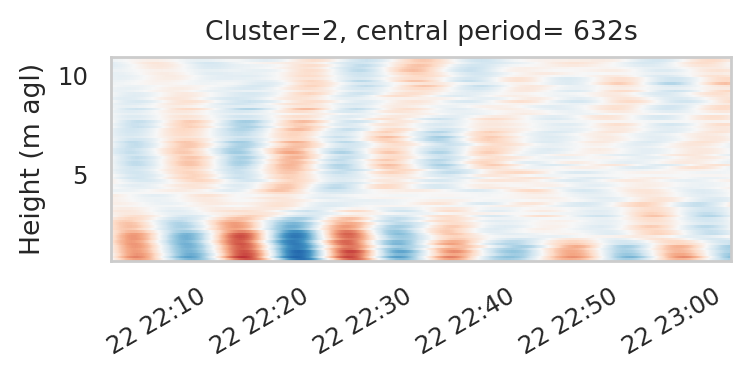

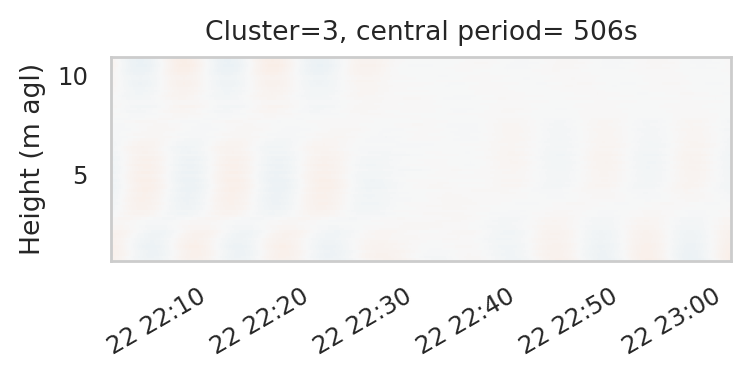

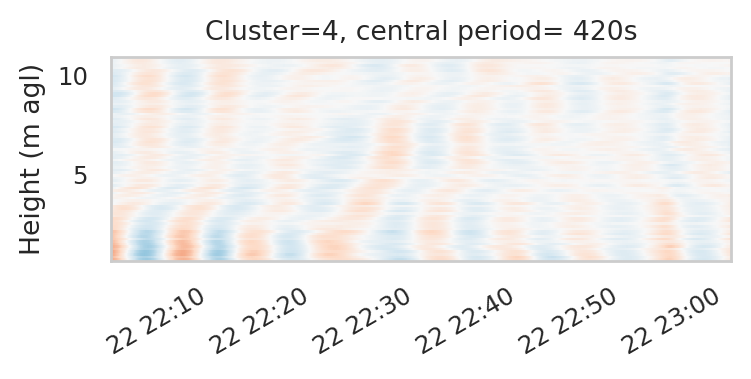

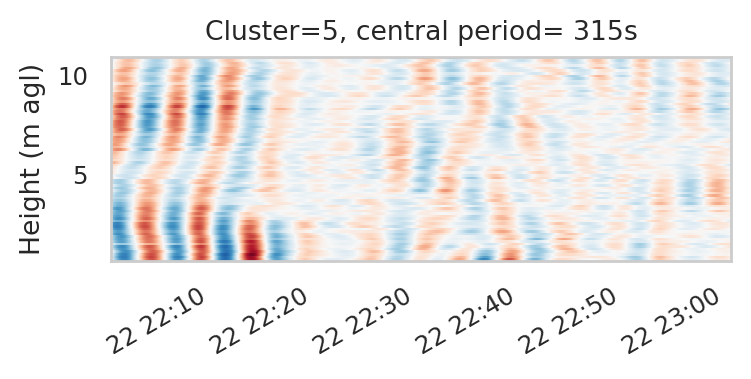

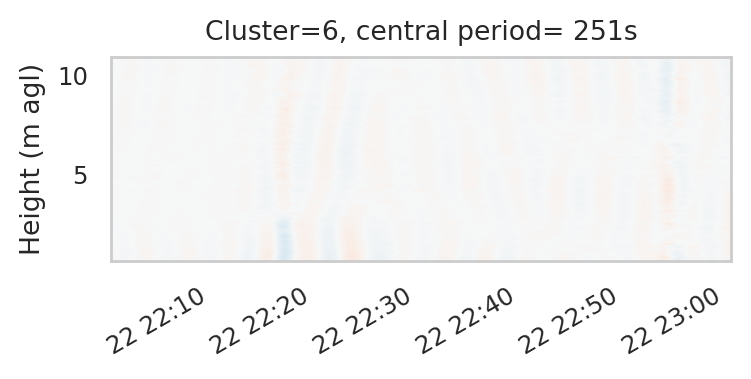

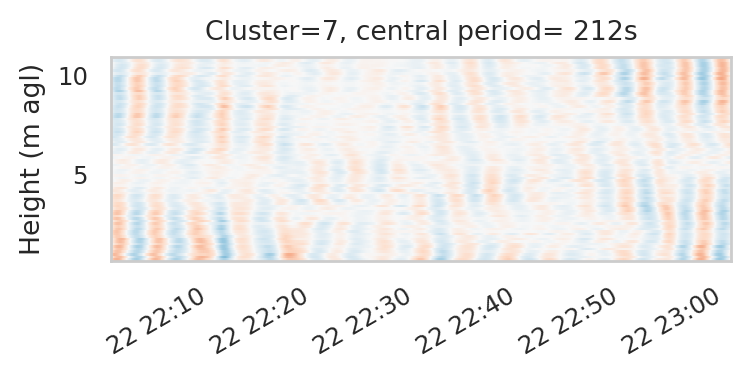

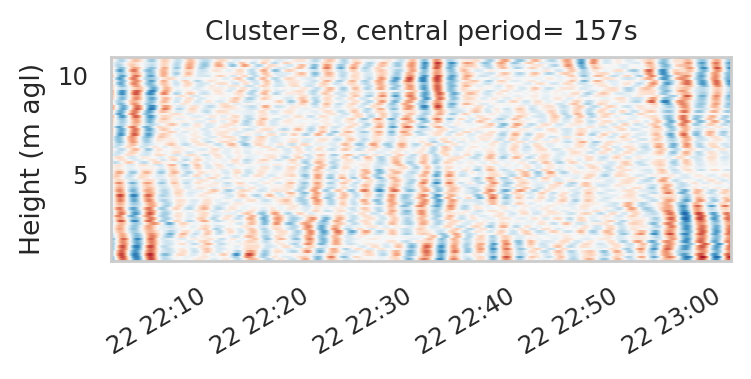

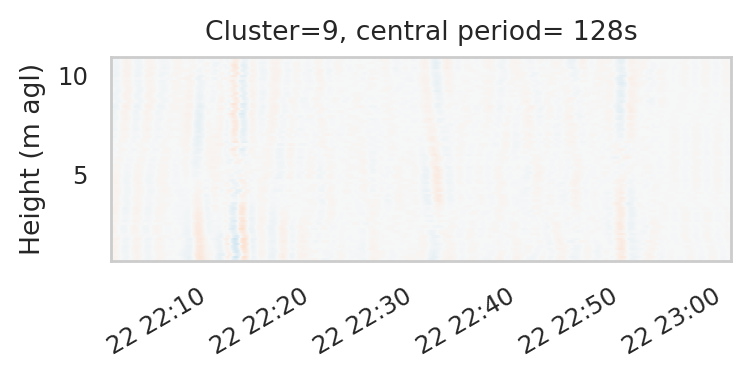

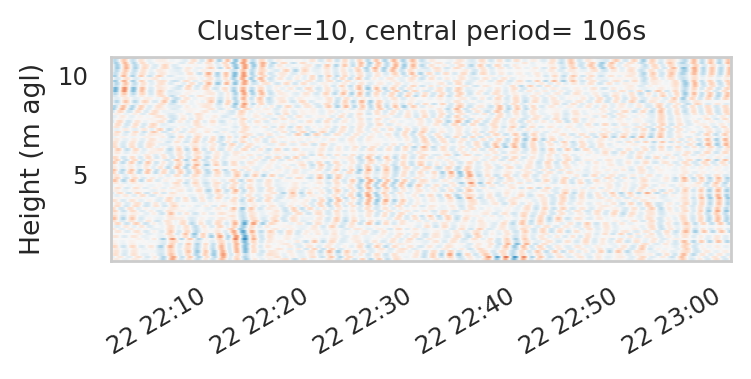

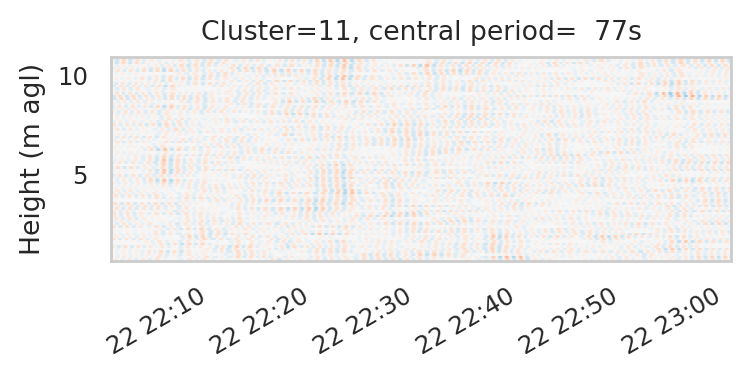

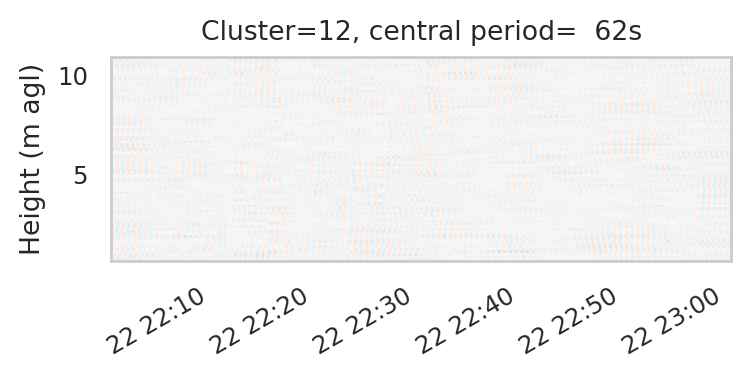

In [32]:
cluster_centers_periods = 1 / (10 ** (cluster_centroids) / (2 * np.pi))

for ncl_center, cl_center in enumerate(cluster_centers_periods):
    if cl_center < 60:
        continue
    plt.figure(figsize=(4, 1.5))
    plt.pcolormesh(
        ds_data.time,
        ds_data.z,
        xr_sep[:, ncl_center, :, :].sum(axis=0),
        vmin=-.5,
        vmax=0.5,
        cmap='RdBu_r'
    )
    plt.gca().set_title(
        'Cluster={}, central period={:4.0f}s'.format(
            ncl_center,
            cl_center
        )
    )
    plt.gca().set_ylabel('Height (m agl)')
    plt.gcf().autofmt_xdate()

These discrete, coherent modes are a major breakthrough. No other method can separate them out.

Some of the modes are clearly very small amplitude, while others make up a dominant process scale.

What about the slow background mode?

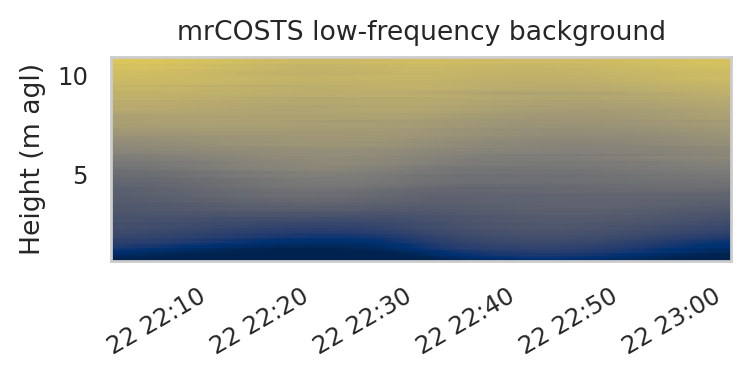

In [33]:
plt.figure(figsize=(4, 1.5))
plt.pcolormesh(
    ds_data.time,
    ds_data.z,
    xr_background,
    vmin=-2,
    vmax=2,
    cmap='cividis'
)
plt.gca().set_title(
    'mrCOSTS low-frequency background'
)
plt.gca().set_ylabel('Height (m agl)')
plt.gcf().autofmt_xdate()

## Converting to xarray

You may have noted in the above code the somewhat complicated indexing, specifically selecting the correct frequency band in axis one and summing across decomposition levels in axis 0 in order to plot the time-space components held in the last two axes. This indexing problem only gets more complicated when considering non-1D data.

It is for precisely this problem that the xarray package was developed. Xarray allows us to name the dimensions and perform operations, such as indexing, using the named dimensions.

In [89]:
ds_xr_sep = xr.DataArray(
    xr_sep.real,
    dims=["decomp_level", "cluster", "z", "time"],
    coords=[np.arange(len(mrc.costs_array)), np.arange(n_optimal), ds_data.z, ds_data.time]
)
ds_cluster_centers = xr.DataArray(
    1 / (10 ** (cluster_centroids) / (2 * np.pi)),
    dims=['cluster'],
    coords=[np.arange(n_optimal)],
)
ds_cluster_centers.attrs['units'] = 's'
ds_cluster_centers.attrs['long_name'] = 'Central period of each period band'

ds_global_separation = ds_xr_sep.to_dataset(name='frequency_bands')
ds_global_separation['frequency_bands'].attrs['units'] = 'K'
ds_global_separation['frequency_bands'].attrs['long_name'] = 'mrCOSTS'

ds_global_separation.coords['cluster_centers'] = ds_cluster_centers

ds_global_separation['background'] = (('z', 'time'), xr_background)

ds_global_separation

<xarray.Dataset>
Dimensions:          (decomp_level: 5, cluster: 17, z: 80, time: 3616)
Coordinates:
  * decomp_level     (decomp_level) int64 0 1 2 3 4
  * cluster          (cluster) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * z                (z) float64 0.7173 0.8461 0.9749 1.104 ... 10.64 10.77 10.9
  * time             (time) datetime64[ns] 2019-07-22T22:00:22 ... 2019-07-22...
    cluster_centers  (cluster) float64 1.283e+03 853.2 631.7 ... 30.53 23.06
Data variables:
    frequency_bands  (decomp_level, cluster, z, time) float64 0.0 0.0 ... 0.0
    background       (z, time) float64 -2.023 -2.024 -2.024 ... 1.395 1.395

## Global reconstruction

Now we just sum across the `decomp_level` and `cluster` dimensions in order to do the global reconstruction.

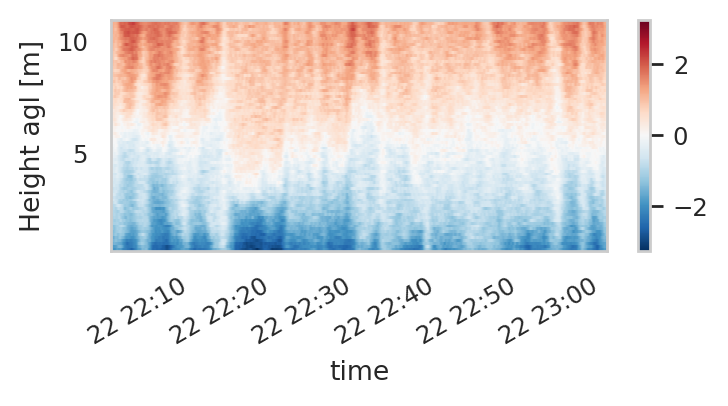

In [84]:
ds_global_reconstruction = (
    ds_global_separation['frequency_bands'].sum(dim=['decomp_level', 'cluster'])
    + ds_global_separation['background']
)
ds_global_reconstruction.plot(figsize=(4, 1.5))

And to compare to the original data...

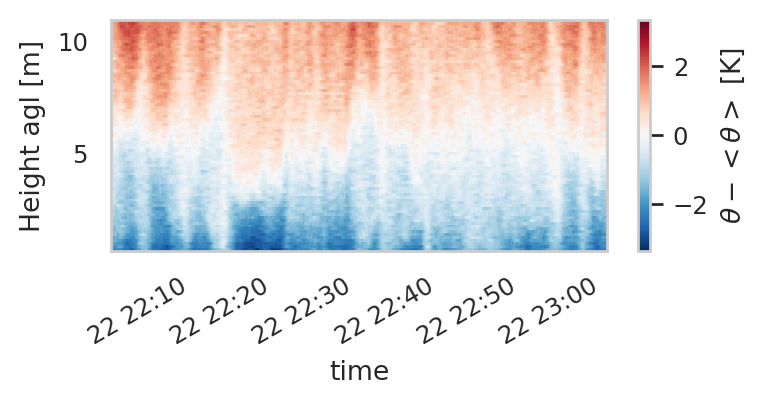

In [85]:
ds_data.plot(figsize=(4, 1.5))

And now for the error (in absolute units) for the global reconstruction.

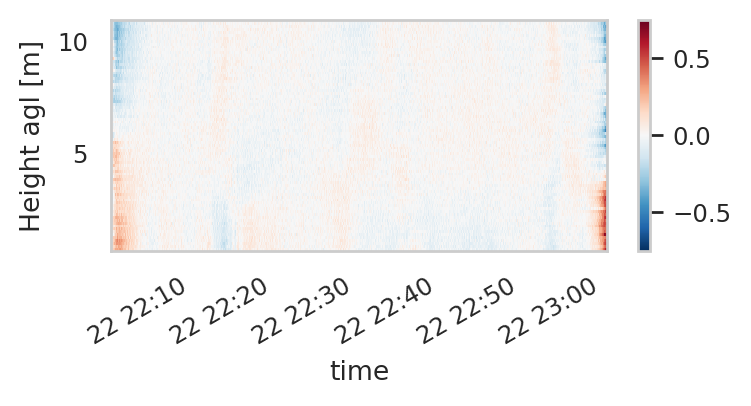

In [86]:
(ds_global_reconstruction - ds_data).plot(figsize=(4, 1.5))

Most of the error is at the edges, where the window reconstruction uncertainty is the largest. Its a very good reconstruction!

## At a point

Plots of time series are generally easier for intuitive interpretation. For this reason we can generate plots of the observations, global reconstruction, and scale separation at a couple different locations.

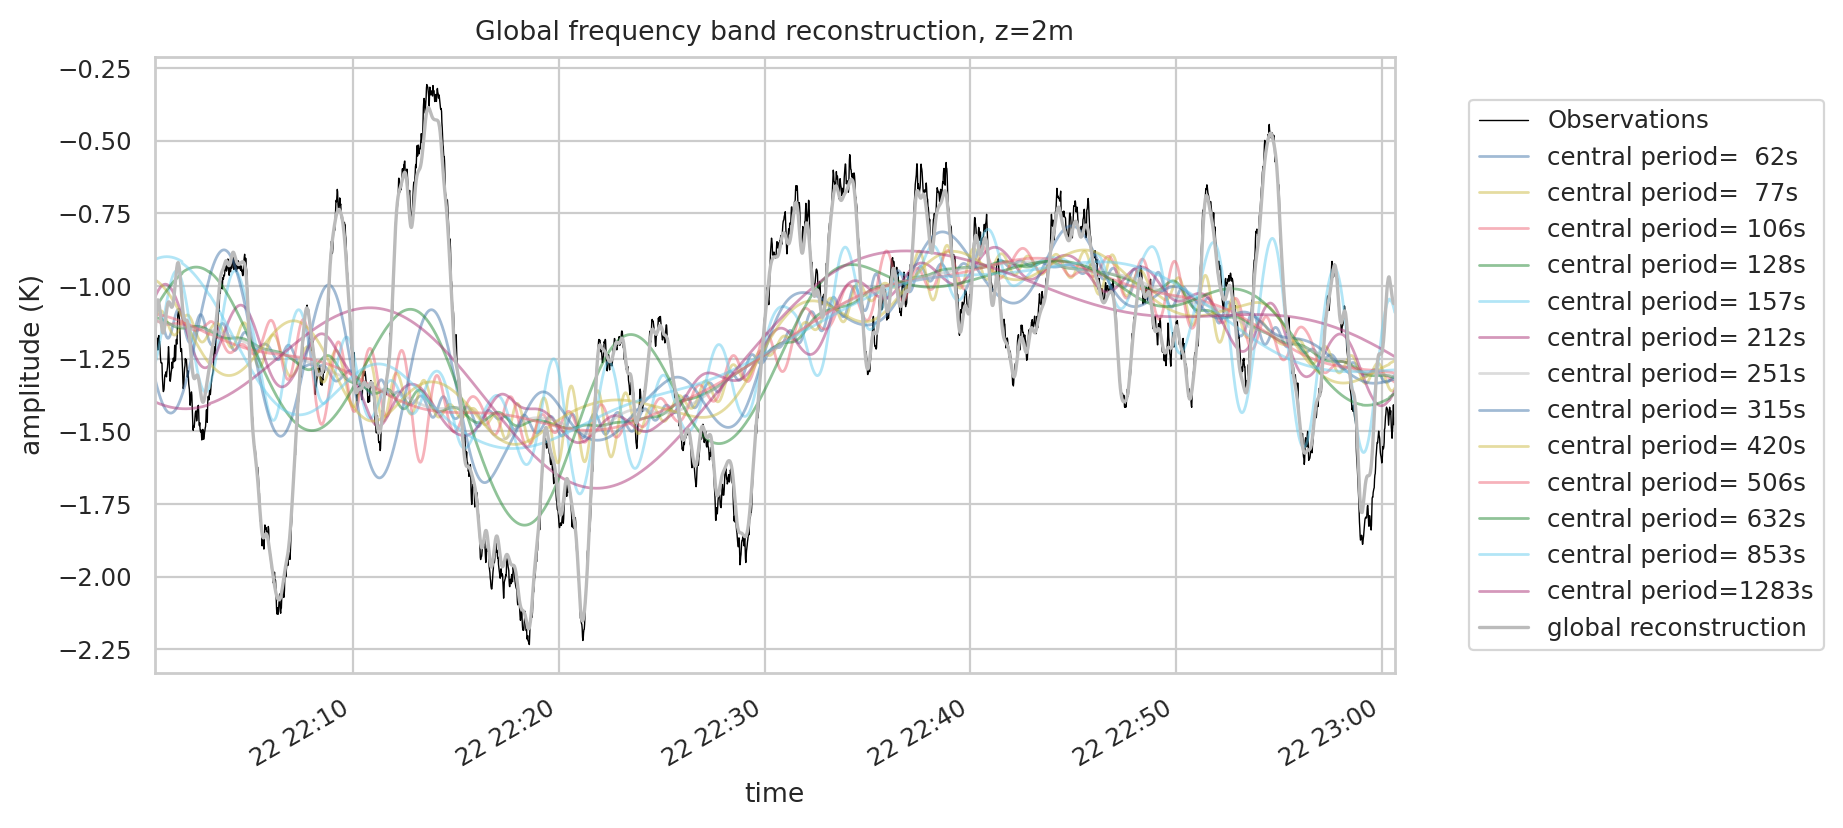

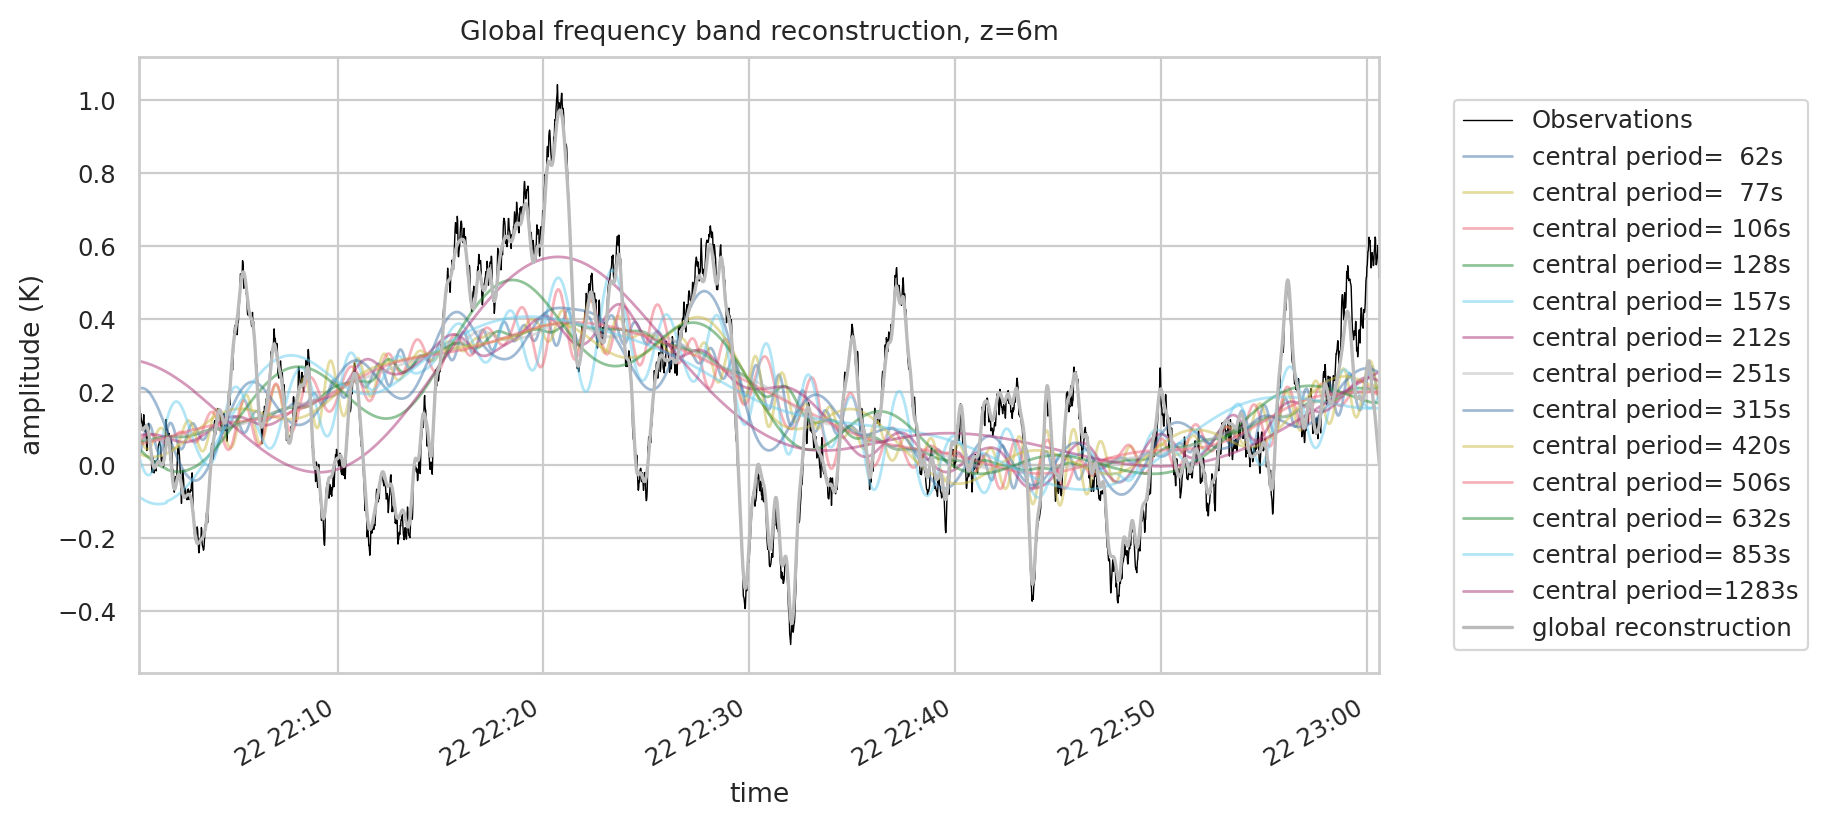

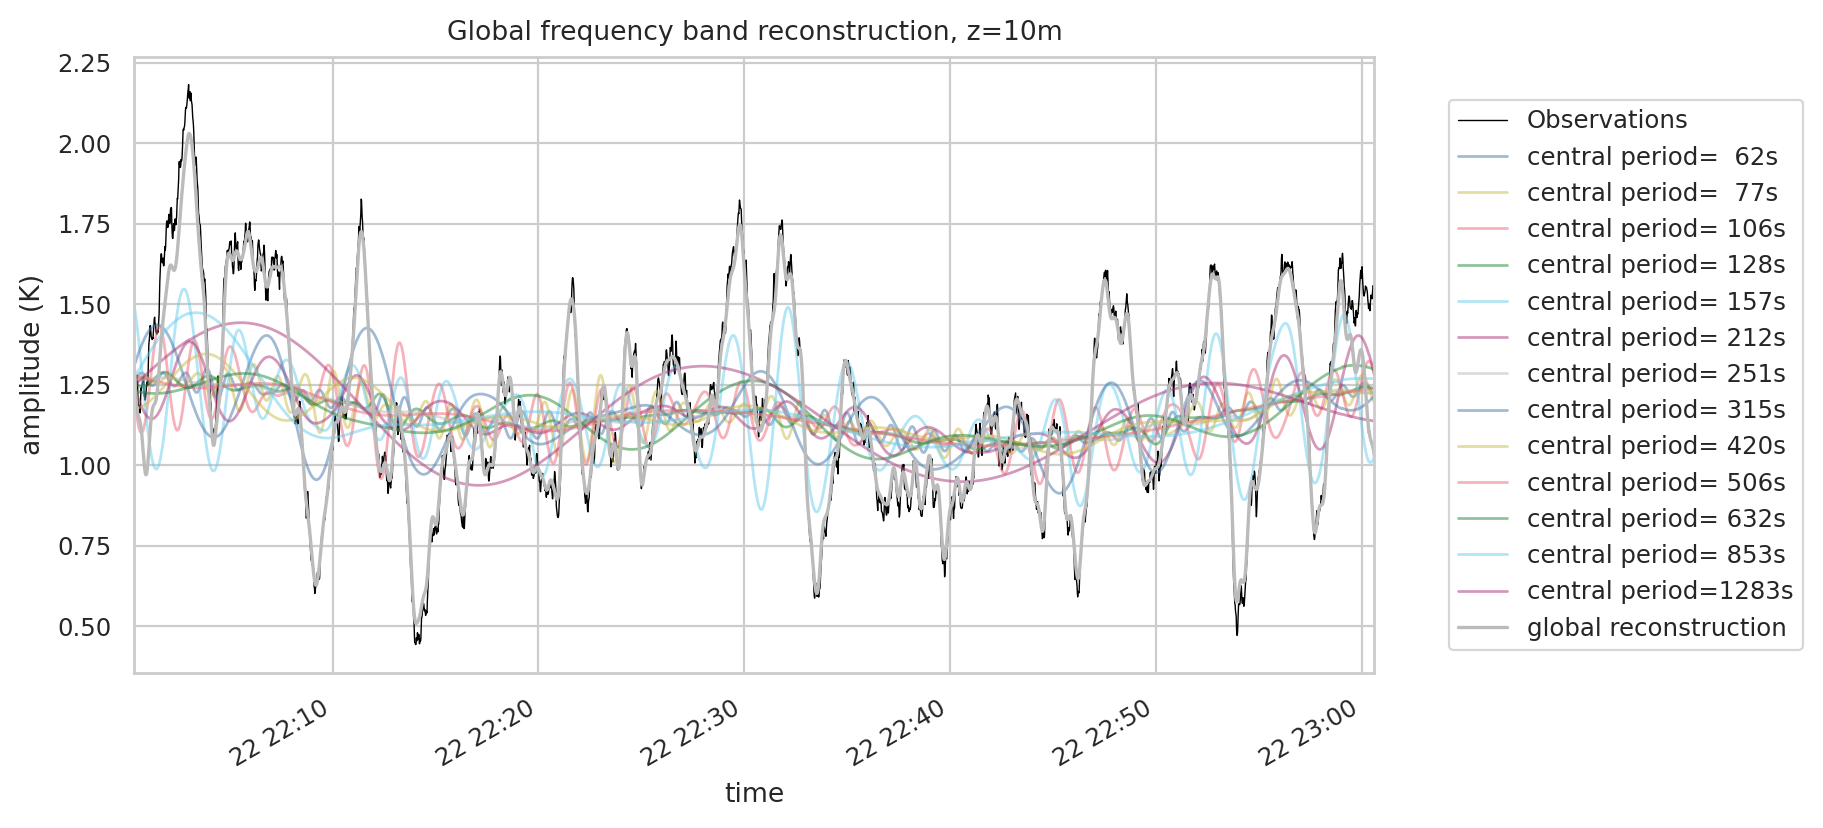

In [87]:
for z in [2, 6, 10]:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ground_truth = ds_data.sel(z=z, method='nearest')
    ground_truth = ground_truth
    ground_truth.plot(ax=ax, color='k', lw=0.5, label='Observations')

    background = ds_global_separation['background'].sel(z=z, method='nearest')
    
    for ncl, cl_center in enumerate(ds_global_separation.cluster_centers[::-1]):
        if cl_center < 60:
            continue
        ds_plot = (
            ds_global_separation['frequency_bands']
            .swap_dims({'cluster': 'cluster_centers'})
            .sel(cluster_centers=cl_center)
            .sel(z=z, method='nearest')
        ).sum(dim='decomp_level')
        label = 'central period={:4.0f}s'.format(cl_center.values)
        (ds_plot + background).plot(ax=ax, label=label, lw=1, alpha=0.5)

    ds_global_reconstruction.sel(z=z, method='nearest').plot(label='global reconstruction')

    # ax.legend()
    ax.legend(bbox_to_anchor=(1.05, 0.95))
    ax.set_title('Global frequency band reconstruction, z={}m'.format(z))
    ax.set_ylabel('amplitude (K)')
    ax.autoscale(enable=True, axis='x', tight=True)

## Visualizing the leaked componenet between levels

Here we use the cluster with the 3rd longest period. It is split across the last two decomposition levels.

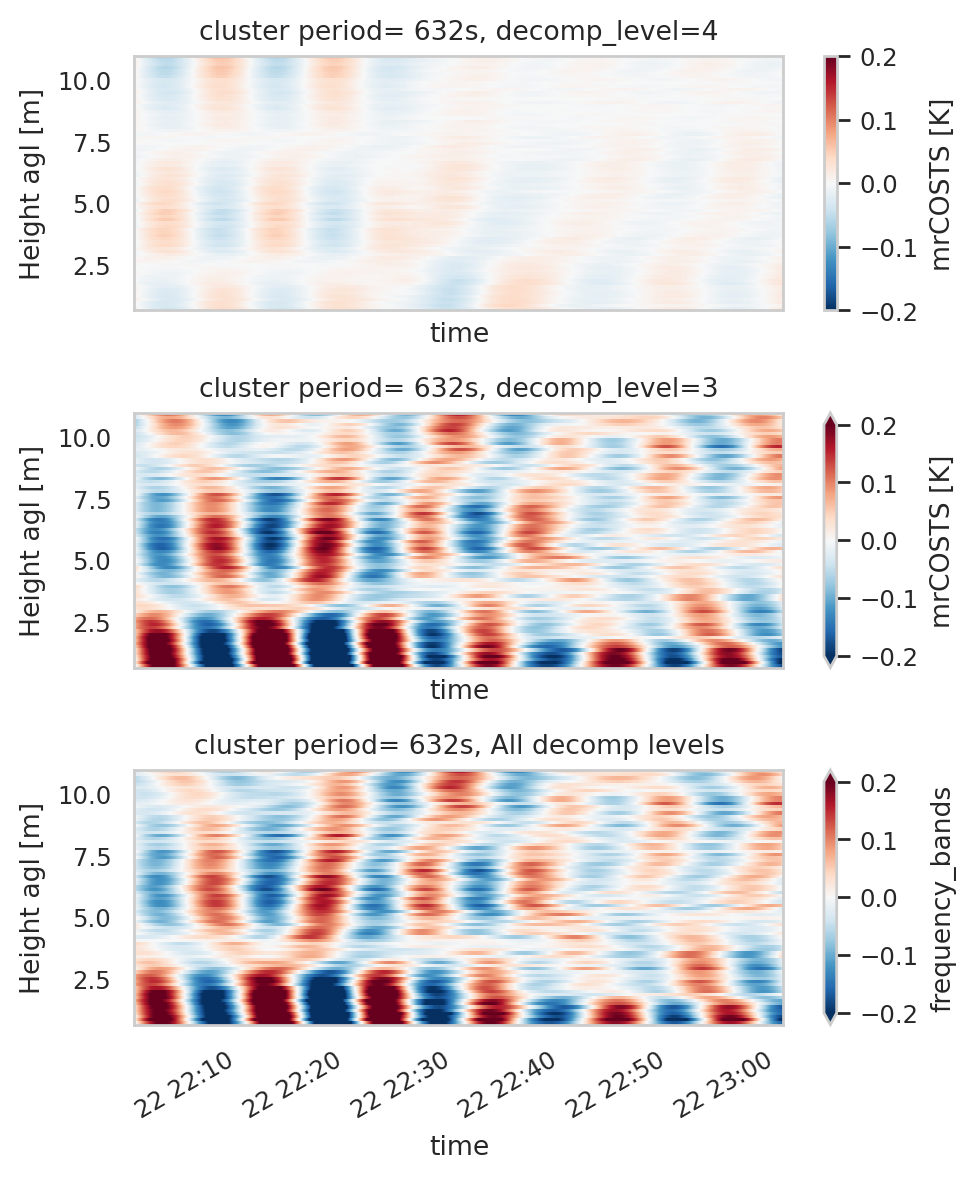

In [97]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(5, 6))
plot_kwargs = {'vmin': -.2, 'vmax': 0.2, 'cmap':'RdBu_r'}

ds_plot = ds_global_separation['frequency_bands'].isel(cluster=2).sel(decomp_level=4)
ds_plot.plot(ax=axes[0], **plot_kwargs)
axes[0].set_title(
    'cluster period={:4.0f}s, decomp_level={}'.format(
        ds_plot.cluster_centers.values,
        ds_plot.decomp_level.values
    )
)

ds_plot = ds_global_separation['frequency_bands'].isel(cluster=2).sel(decomp_level=3)
ds_plot.plot(ax=axes[1], **plot_kwargs)
axes[1].set_title(
    'cluster period={:4.0f}s, decomp_level={}'.format(
        ds_plot.cluster_centers.values,
        ds_plot.decomp_level.values
    )
)

ds_plot = ds_global_separation['frequency_bands'].isel(cluster=2)
ds_plot = ds_plot.sum(dim='decomp_level')
ds_plot.plot(ax=axes[2], **plot_kwargs)
axes[2].set_title(
    'cluster period={:4.0f}s, All decomp levels'.format(
        ds_plot.cluster_centers.values,
    )
)

fig.tight_layout()

The leaked component is generally small amplitude.